# Utilities

In [1]:
%gui wx
import os
from utils import loadFSL, FSLeyesServer, mkdir_no_exist, DownloadProgressBar, download_url, direct_file_download_open_neuro, get_json_from_file
os.environ["DIPY_HOME"] = "./data/"
loadFSL()
import fsl.wrappers
from fsl.wrappers import fslmaths, mcflirt
import mne_nirs
import nilearn
from nilearn.datasets import fetch_development_fmri
import mne
import mne_nirs
import dipy
from dipy.data import fetch_bundles_2_subjects, read_bundles_2_subjects
import xml.etree.ElementTree as ET
import os.path as op
import nibabel as nib
import glob
import ants
import openneuro
from mne.datasets import sample
from mne_bids import BIDSPath, read_raw_bids, print_dir_tree, make_report
import requests
import urllib.request
from tqdm import tqdm
from fsl.wrappers import fast, bet
from fsl.wrappers.misc import fslroi
from fsl.wrappers import flirt
import glob
import pandas as pd
import numpy as np
import json
import subprocess
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2
from utilities import get_skull_stripped_anatomical, apply_python_mask_approach, launch_freeview, fsl_anat_wrapped, load_mot_params_fsl_6_dof, compute_FD_power

In [3]:
%%capture
fsleyesDisplay = FSLeyesServer()
fsleyesDisplay.show()


(ipykernel_launcher.py:67123): Gtk-WARNING **: 15:32:35.562: Negative content width -1 (allocation 1, extents 1x1) while allocating gadget (node spinbutton, owner GtkSpinButton)

(ipykernel_launcher.py:67123): Gtk-WARNING **: 15:32:35.562: for_size smaller than min-size (1 < 32) while measuring gadget (node entry, owner GtkSpinButton)

(ipykernel_launcher.py:67123): Gtk-WARNING **: 15:32:35.562: for_size smaller than min-size (1 < 16) while measuring gadget (node button, owner GtkSpinButton)

(ipykernel_launcher.py:67123): Gtk-WARNING **: 15:32:35.562: for_size smaller than min-size (1 < 16) while measuring gadget (node button, owner GtkSpinButton)


# Folders

In [4]:
dataset_id = 'ds000171' 
subject_id = 'control01'    
sample_path = "./data/" 
os.makedirs(sample_path, exist_ok=True)
bids_root = op.join(sample_path, dataset_id)
deriv_root = op.join(bids_root, 'derivatives') 
preproc_root = op.join(bids_root, 'derivatives', 'preprocessed_data') 
os.makedirs(bids_root, exist_ok=True)
subject_dir = 'sub-{}'.format(subject_id)

## Download

In [7]:
subprocess.run(["openneuro-py", "download", "--dataset", dataset_id, 
                "--target-dir", bids_root, 
                "--include", op.join(subject_dir, '*'),    
               ], check=False) 
os.makedirs(op.join(bids_root, 'derivatives'), exist_ok=True)
preproc_root = op.join(bids_root, 'derivatives', 'preprocessed_data') 
os.makedirs(op.join(preproc_root, subject_dir), exist_ok=True)
os.makedirs(op.join(preproc_root, subject_dir, 'anat'), exist_ok=True)
os.makedirs(op.join(preproc_root, subject_dir, 'func'), exist_ok=True)
os.makedirs(op.join(preproc_root, subject_dir, 'fmap'), exist_ok=True)


👋 Hello! This is openneuro-py 2024.2.0. Great to see you! 🤗

   👉 Please report problems 🤯 and bugs 🪲 at
      https://github.com/hoechenberger/openneuro-py/issues

🌍 Preparing to download ds000171 …


📁 Traversing directories for ds000171 : 436 entities [00:35, 12.17 entities/s]


📥 Retrieving up to 15 files (5 concurrent downloads). 


sub-control01_T1w.nii.gz:   0%|          | 24.2k/8.77M [00:00<00:37, 245kB/s]
sub-control01_task-music_run-1_bold.nii.gz:   0%|          | 0.00/33.8M [00:00<?, ?B/s]

sub-control01_task-music_run-2_events.tsv:   0%|          | 0.00/339 [00:00<?, ?B/s]

sub-control01_T1w.nii.gz:   1%|          | 74.2k/8.77M [00:00<00:24, 377kB/s]       

sub-control01_task-music_run-3_bold.nii.gz:   0%|          | 0.00/33.9M [00:00<?, ?B/s]


sub-control01_task-music_run-2_bold.nii.gz:   0%|          | 0.00/33.9M [00:00<?, ?B/s]
sub-control01_T1w.nii.gz:   2%|▏         | 155k/8.77M [00:00<00:15, 572kB/s] 00<01:48, 327kB/s]

sub-control01_task-music_run-3_bold.nii.gz:   0%|          | 32.6k/33.9M [00:00<01:51, 318kB/s]


sub-control01_task-music_run-2_bold.nii.gz:   0%|          | 32.6k/33.9M [00:00<01:57, 301kB/s]
sub-control01_task-music_run-1_bold.nii.gz:   0%|          | 66.5k/33.8M [00:00<01:47, 331kB/s]

sub-control01_task-music_run-3_bold.nii.gz:   0%|          | 83.6k/33.9M [00:00<01:22, 430kB/s]

✅ Finished downloading ds000171.
 
🧠 Please enjoy your brains.
 



sub-control01_task-music_run-1_bold.nii.gz: 100%|█████████▉| 33.7M/33.8M [00:38<00:00, 2.02MB/s]
                                                                                                

In [5]:
%%capture
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(op.join(bids_root, 'sub-control01', 'anat', 'sub-control01_T1w.nii.gz')) 


(ipykernel_launcher.py:76222): Gtk-CRITICAL **: 22:25:30.011: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed

(ipykernel_launcher.py:76222): Gtk-CRITICAL **: 22:25:30.039: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed



(ipykernel_launcher.py:76222): Gtk-WARNING **: 22:25:30.097: Negative content width -1 (allocation 1, extents 1x1) while allocating gadget (node spinbutton, owner GtkSpinButton)

(ipykernel_launcher.py:76222): Gtk-WARNING **: 22:25:30.097: for_size smaller than min-size (1 < 32) while measuring gadget (node entry, owner GtkSpinButton)

(ipykernel_launcher.py:76222): Gtk-WARNING **: 22:25:30.097: for_size smaller than min-size (1 < 16) while measuring gadget (node button, owner GtkSpinButton)

(ipykernel_launcher.py:76222): Gtk-WARNING **: 22:25:30.097: for_size smaller than min-size (1 < 16) while measuring gadget (node button, owner GtkSpinButton)


# Skull stripping

###  Preprocessing and BIDs
An important part of **anatomical** preprocessing is to remove the skull around the brain.
To adhere to the BIDs format, all modified files should be put in a new folder, called derivatives, such that you always have clean data in the source directory. The derivatives folder can be used for different preprocessing and treatments, each needing their own subfolders. In our case, we've created a single folder, preprocessed_data, hence the following structure:

In [5]:
resulting_mask_path = op.join(preproc_root, subject_dir, 'anat', 'sub-{}_T1w_mask'.format(subject_id) ) 

In [ ]:
get_skull_stripped_anatomical(bids_root, preproc_root, "control01") 

In [7]:
fsleyesDisplay.load(resulting_mask_path)


(ipykernel_launcher.py:76222): Gtk-CRITICAL **: 22:25:46.225: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed

(ipykernel_launcher.py:76222): Gtk-CRITICAL **: 22:25:46.245: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed


### Improving the fit
If you look a bit into bet's documentation, you'll quickly find that there are parameters with which you can play; robust brain centre estimation and fractional intensity threshold. To demonstrate the importance and impact of these parameters, let's use a robust brain center estimation.

In [ ]:
get_skull_stripped_anatomical(bids_root, preproc_root, "control01", robust=True)

In [10]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(op.join(bids_root, 'sub-control01', 'anat', 'sub-control01_T1w.nii.gz'))
fsleyesDisplay.load(resulting_mask_path)


(ipykernel_launcher.py:76222): Gtk-CRITICAL **: 22:26:16.239: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed

(ipykernel_launcher.py:76222): Gtk-CRITICAL **: 22:26:16.260: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed

(ipykernel_launcher.py:76222): Gtk-CRITICAL **: 22:26:16.422: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed

(ipykernel_launcher.py:76222): Gtk-CRITICAL **: 22:26:16.446: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed



(ipykernel_launcher.py:76222): Gtk-WARNING **: 22:26:16.508: Negative content width -1 (allocation 1, extents 1x1) while allocating gadget (node spinbutton, owner GtkSpinButton)

(ipykernel_launcher.py:76222): Gtk-WARNING **: 22:26:16.508: for_size smaller than min-size (1 < 32) while measuring gadget (node entry, owner GtkSpinButton)

(ipykernel_launcher.py:76222): Gtk-WARNING **: 22:26:16.508: for_size smaller than min-size (1 < 16) while measuring gadget (node button, owner GtkSpinButton)

(ipykernel_launcher.py:76222): Gtk-WARNING **: 22:26:16.508: for_size smaller than min-size (1 < 16) while measuring gadget (node button, owner GtkSpinButton)


### 1.1.4 Manual corrections
If you really want good fit, you might want to resort to **manually correcting the mask**. Run the code above to check whether the result is satisfactory or not. 

FSLeyes readily allows you to do such things! While on FSLeyes, press **Alt + E** to open the editing interface.

>Edit


You can then escape back to the non-edit mode by pressing again **Alt + E**


In [9]:
anatomical_path = op.join(bids_root, 'sub-control01', 'anat', 'sub-control01_T1w.nii.gz')
betted_brain_path = op.join(preproc_root, 'sub-control01', 'anat', 'sub-control01_T1w.nii.gz') 
resulting_mask_path = op.join(preproc_root, 'sub-control01', 'anat', 'sub-control01_T1w_mask.nii.gz') 

In [6]:
apply_python_mask_approach(anatomical_path, resulting_mask_path, betted_brain_path)

In [12]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(betted_brain_path)


(ipykernel_launcher.py:76222): Gtk-CRITICAL **: 22:26:31.668: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed

(ipykernel_launcher.py:76222): Gtk-CRITICAL **: 22:26:31.689: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed

(ipykernel_launcher.py:76222): Gtk-CRITICAL **: 22:26:32.527: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed

(ipykernel_launcher.py:76222): Gtk-CRITICAL **: 22:26:32.547: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed



(ipykernel_launcher.py:76222): Gtk-WARNING **: 22:26:32.605: Negative content width -1 (allocation 1, extents 1x1) while allocating gadget (node spinbutton, owner GtkSpinButton)

(ipykernel_launcher.py:76222): Gtk-WARNING **: 22:26:32.605: for_size smaller than min-size (1 < 32) while measuring gadget (node entry, owner GtkSpinButton)

(ipykernel_launcher.py:76222): Gtk-WARNING **: 22:26:32.605: for_size smaller than min-size (1 < 16) while measuring gadget (node button, owner GtkSpinButton)

(ipykernel_launcher.py:76222): Gtk-WARNING **: 22:26:32.605: for_size smaller than min-size (1 < 16) while measuring gadget (node button, owner GtkSpinButton)


## 1.2 Tissue segmentation

For the purpose of analysis, it can be useful to separate the tissues into tissue classes; in particular extracting the white matter, grey matter and cerebrospinal fluid (abreviated as CSF) is very interesting in fMRI analysis

It is perfectly possible (even likely) that FSLeyes will stop responding over the course of this lab. This is perfectly normal! Simply wait for whichever function (such as FAST) to finish and it should start responding again, don't worry too quickly, be patient :)</p>


Note that FAST will take one or two minutes to run, this is expected, do not panic :)

In [10]:
betted_brain_path = op.join(preproc_root, 'sub-control01', 'anat', 'sub-control01_T1w')
fast_target = betted_brain_path 

In [ ]:

[os.remove(f) for f in glob.glob(op.join(preproc_root, 'sub-control01', 'anat', '*fast*'))]
segmentation_path = op.join(preproc_root, 'sub-control01', 'anat', 'sub-control01_T1w_fast')
fast(imgs=[fast_target], out=segmentation_path, n_classes=3)

Let's check the quality of the segmentation, shall we?
We want to extract 3 tissue types here: the white matter, the grey matter and the csf. How well did fast perform?

In [ ]:
print_dir_tree(bids_root, max_depth=5)

The pve files correspond to our segmented tissues. We have exactly three files, because we set n_classes to 3 above:
```python
fast(..., n_classes=3)


To make it easier on you, we will display:

- pve_0 in <span style="color:red;">red</span>
- pve_1 in <span style="color:green;">green</span>
- pve_2 in <span style="color:blue;">blue</span>

In [14]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(betted_brain_path)
# CSF
fsleyesDisplay.load(glob.glob(op.join(preproc_root, 'sub-control01', 'anat','*pve_0*'))[0])
# GM
fsleyesDisplay.load(glob.glob(op.join(preproc_root, 'sub-control01', 'anat','*pve_1*'))[0])
# WM
fsleyesDisplay.load(glob.glob(op.join(preproc_root, 'sub-control01', 'anat','*pve_2*'))[0])

fsleyesDisplay.displayCtx.getOpts(fsleyesDisplay.overlayList[1]).cmap = 'Red'
fsleyesDisplay.displayCtx.getOpts(fsleyesDisplay.overlayList[2]).cmap = 'Green'
fsleyesDisplay.displayCtx.getOpts(fsleyesDisplay.overlayList[3]).cmap = 'Blue'



(ipykernel_launcher.py:76222): Gtk-CRITICAL **: 22:26:55.981: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed

(ipykernel_launcher.py:76222): Gtk-CRITICAL **: 22:26:56.005: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed

(ipykernel_launcher.py:76222): Gtk-CRITICAL **: 22:26:56.234: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed

(ipykernel_launcher.py:76222): Gtk-CRITICAL **: 22:26:56.257: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed

(ipykernel_launcher.py:76222): Gtk-CRITICAL **: 22:26:56.507: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed

(ipykernel_launcher.py:76222): Gtk-CRITICAL **: 22:26:56.530: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed

(ipykernel_launcher.py:76222): Gtk-CRITICAL **: 22:26:56.765: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed


(ipykernel_launcher.py:76222): Gtk-WARNING **: 22:26:56.874: Negative content width -1 (allocation 1, extents 1x1) while allocating gadget (node spinbutton, owner GtkSpinButton)

(ipykernel_launcher.py:76222): Gtk-WARNING **: 22:26:56.874: for_size smaller than min-size (1 < 32) while measuring gadget (node entry, owner GtkSpinButton)

(ipykernel_launcher.py:76222): Gtk-WARNING **: 22:26:56.874: for_size smaller than min-size (1 < 16) while measuring gadget (node button, owner GtkSpinButton)

(ipykernel_launcher.py:76222): Gtk-WARNING **: 22:26:56.874: for_size smaller than min-size (1 < 16) while measuring gadget (node button, owner GtkSpinButton)


# Coregistration of images, a critical preprocessing step

In principle, it could be done manually

In [15]:
import threading


# List of images to load in Freeview. 
# img_list contains paths to neuroimaging files you want to visualize:
# A standard anatomical template (MNI152) for reference.
# A subject-specific anatomical image with a specific colormap (greyscale).
imgList = [
    op.expandvars('$FSLDIR/data/standard/MNI152_T1_1mm.nii.gz'), # Path to the standard MNI template image
    op.join(preproc_root, "sub-control01", "anat", "sub-control01_T1w.nii.gz:colormap=greyscale") # Path to the subject's anatomical image with colormap set to greyscale
    # You can modify this list to add any other images you want to view in .nii.gz format
]

# Create a new thread to run Freeview with the list of images
# We pass the target function (launch_freeview) and the arguments (imgList,)
# The comma is necessary to pass a tuple to 'args' so threading works correctly
freeview_thread = threading.Thread(target=launch_freeview, args=(imgList,))

# Start the thread to launch Freeview in the background
freeview_thread.start()

# Print a message indicating that Freeview is running in a separate thread
print("Freeview is running in a separate thread.")


Freeview is running in a separate thread.


--------------------------------------------------------------------------
ERROR: FreeSurfer license file /usr/local/freesurfer/7.4.1-1//.license not found.
  If you are outside the NMR-Martinos Center,
  go to http://surfer.nmr.mgh.harvard.edu/registration.html to 
  get a valid license file (it's free).
  If you are inside the NMR-Martinos Center,
  make sure to source the standard environment.
  A path to an alternative license file can also be
  specified with the FS_LICENSE environmental variable.
--------------------------------------------------------------------------


Wait, we can't see anything apart from the top brain. No worries! Simply set the background to be transparent by ticking the Clear Background option, as in the picture below:


### Manual approach

Let's start with a straightforward approach: you will align the images manually. In Freeview, click in Tools > Transform Volume.
You should get the following panel:

Now, play with the sliders of translation and rotation to align the anatomical to the reference. </b> Try to align the two brains as best you can.</p>


The MRI and the template are not very well aligned, but we can try to make them more aligned. Specifically, we would like to find a transformation such that we can align our anatomical to the MNI template. This is the so-called normalization step.

### Types of normalization

So, you now know that you need a transformation and a reference. Great. Now, the transformation you allow can be of two types: it can be linear, meaning whatever you apply will be the same across the entire image, or non linear, where each voxel gets a separate treatment

(ducky linear and non linear)



## Actually doing it: Linear normalization

To perform linear normalization, the idea is simple. The transformation we want should be linear - ie, affine.
Such a matching is usually called in image processing **image registration**. Here, we're dealing with 3D data, so the problem is a bit more complicated. Fortunately all of this has been coded by very smart people, and to our rescue comes a tool specifically to register volumes to each other.

This tool can allow many registrations and is extremely powerful. In its most basic form, it expects:
- An input volume, the volume you want to register (Ducky's sunglasses)
- A reference volume, to which the input is registered (Ducky's body)
- An output volume, the result of the transformation (Ducky's sunglasses once they are on Ducky's beak)

Here is how you can call it to register the patient's anatomical to some reference sitting in another space (here the MNI152 template):
```python
flirt()
```
💡 Pay attention! 💡
    FLIRT expects the anatomical to be skull stripped to maximize normalization. Luckily, you already did it before with BET.</p>


In [11]:
subject_id = 'control01' 
subject_anatomical = op.join(preproc_root, 'sub-{}'.format(subject_id), 'anat', 'sub-control01_T1w')
mni_template = op.expandvars(op.join('$FSLDIR', 'data', 'standard', 'MNI152_T1_1mm_brain'))

target = subject_anatomical 
reference = mni_template 
result = op.join(preproc_root, 'sub-{}'.format(subject_id), 'anat', 'sub-{}_T1w_mni'.format(subject_id))

In [ ]:

flirt(target, reference, out=result)

Visualize the result of flirt on top of the reference. What do you think of alignment?

In [17]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(reference) 
fsleyesDisplay.load(result)


(ipykernel_launcher.py:76222): Gtk-CRITICAL **: 22:28:24.119: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed

(ipykernel_launcher.py:76222): Gtk-CRITICAL **: 22:28:24.145: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed

(ipykernel_launcher.py:76222): Gtk-CRITICAL **: 22:28:24.281: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed

(ipykernel_launcher.py:76222): Gtk-CRITICAL **: 22:28:24.305: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed

(ipykernel_launcher.py:76222): Gtk-CRITICAL **: 22:28:24.403: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed

(ipykernel_launcher.py:76222): Gtk-CRITICAL **: 22:28:24.427: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed

(ipykernel_launcher.py:76222): Gtk-CRITICAL **: 22:28:25.577: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed


(ipykernel_launcher.py:76222): Gtk-WARNING **: 22:28:25.892: Negative content width -1 (allocation 1, extents 1x1) while allocating gadget (node spinbutton, owner GtkSpinButton)

(ipykernel_launcher.py:76222): Gtk-WARNING **: 22:28:25.892: for_size smaller than min-size (1 < 32) while measuring gadget (node entry, owner GtkSpinButton)

(ipykernel_launcher.py:76222): Gtk-WARNING **: 22:28:25.892: for_size smaller than min-size (1 < 16) while measuring gadget (node button, owner GtkSpinButton)

(ipykernel_launcher.py:76222): Gtk-WARNING **: 22:28:25.892: for_size smaller than min-size (1 < 16) while measuring gadget (node button, owner GtkSpinButton)

(ipykernel_launcher.py:76222): Gtk-CRITICAL **: 22:28:30.039: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed

(ipykernel_launcher.py:76222): Gtk-CRITICAL **: 22:28:30.060: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed


Which cost should we use? If you were in a pure void, there would be no right or wrong answer from the get-go. No choice but to experiment and find out!

Hopefully, <a href="https://fsl.fmrib.ox.ac.uk/fsl/docs/#/registration/flirt/user_guide?id=flirt">the documentation</a> should give you some pointers. What you want here is to register a T1 to a T1: this is a <u>within</u> modality registration, so you should restrict yourself only to costs appropriate to this type of modality! 

To help you, we've set up a cell that will run the different coregistrations for you. Simply fill in the different costs to consider :)

In [12]:
possible_costs = ['mutualinfo', 'corratio', 'normcorr', 'normmi', 'leastsq', 'labeldiff']
# Define a list of all possible cost functions supported by FLIRT. These include:
# - 'mutualinfo': Mutual information (cross-modalities).
# - 'corratio': Correlation ratio (can work across or within modalities).
# - 'normcorr': Normalized correlation (within-modalities).
# - 'normmi': Normalized mutual information (cross-modalities).
# - 'leastsq': Least squares (within-modalities).
# - 'labeldiff': Label difference (special cases, such as segmentation images).

costs_to_consider = ['leastsq', 'normcorr'] 
# Select the relevant cost functions for within-modalities (T1-to-T1 alignment):
# - 'leastsq': Uses least squares, suitable for aligning images of the same modality.
# - 'normcorr': Uses normalized correlation, also suitable for within-modality alignment.
# FIXME: ISSUE WITH THE LEASTSQ COST RESULT


In [ ]:
for c in costs_to_consider:
    flirt(target, reference, out=result + '_' + c, cost=c)

In [19]:
for c in costs_to_consider:
    fsleyesDisplay.load(result + '_' + c)


(ipykernel_launcher.py:76222): Gtk-CRITICAL **: 22:35:49.361: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed

(ipykernel_launcher.py:76222): Gtk-CRITICAL **: 22:35:49.382: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed

(ipykernel_launcher.py:76222): Gtk-CRITICAL **: 22:35:49.626: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed

(ipykernel_launcher.py:76222): Gtk-CRITICAL **: 22:35:49.648: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed



(ipykernel_launcher.py:76222): Gtk-CRITICAL **: 22:35:53.843: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed

(ipykernel_launcher.py:76222): Gtk-CRITICAL **: 22:35:53.863: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed

(ipykernel_launcher.py:76222): Gtk-CRITICAL **: 22:35:57.128: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed

(ipykernel_launcher.py:76222): Gtk-CRITICAL **: 22:35:57.148: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed

(ipykernel_launcher.py:76222): Gtk-CRITICAL **: 22:35:59.572: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed

(ipykernel_launcher.py:76222): Gtk-CRITICAL **: 22:35:59.593: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed

(ipykernel_launcher.py:76222): Gtk-CRITICAL **: 22:36:00.935: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed

## Non linear normalization

So, you know how to do it linearly.  What if we wanted to do it non-linearly?

With FLIRT, <i>it's painfully hard</i>. To do it, you can use *FNIRT*. 

But, there are other tools available, one of them being <a href="https://github.com/ANTsX/ANTs">ANTs (Advanced Normalization Tools)</a>.
For completeness, we will show you now how to use it (very succinctly) so that you know how to do it.


💡 Pay attention! 💡

FNIRT does NOT expect the input data to be skull-stripped.</p>

In [14]:
moving_image = ants.image_read(target + '.nii.gz')
fixed_image = ants.image_read(reference + '.nii.gz')
resultAnts = op.join(preproc_root, 'sub-{}'.format(subject_id), 'anat', 'sub-{}_T1w_mni_SyN.nii.gz'.format(subject_id))

In [11]:
transformation = ants.registration(fixed=fixed_image, moving=moving_image, type_of_transform='SyN')
warpedImage = ants.apply_transforms(fixed=fixed_image, moving=moving_image, transformlist=transformation['fwdtransforms'])
ants.image_write(warpedImage, resultAnts)

Look at the results and compare it against the linear coregistration. Which one do you prefer? Why?

In [14]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(reference)
fsleyesDisplay.load(result)
fsleyesDisplay.load(resultAnts)


(ipykernel_launcher.py:161839): Gtk-CRITICAL **: 22:59:38.318: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed

(ipykernel_launcher.py:161839): Gtk-CRITICAL **: 22:59:38.340: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed

(ipykernel_launcher.py:161839): Gtk-CRITICAL **: 22:59:38.538: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed

(ipykernel_launcher.py:161839): Gtk-CRITICAL **: 22:59:38.559: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed

(ipykernel_launcher.py:161839): Gtk-CRITICAL **: 22:59:38.753: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed

(ipykernel_launcher.py:161839): Gtk-CRITICAL **: 22:59:38.776: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed



(ipykernel_launcher.py:161839): Gtk-WARNING **: 22:59:38.841: Negative content width -1 (allocation 1, extents 1x1) while allocating gadget (node spinbutton, owner GtkSpinButton)

(ipykernel_launcher.py:161839): Gtk-WARNING **: 22:59:38.841: for_size smaller than min-size (1 < 32) while measuring gadget (node entry, owner GtkSpinButton)

(ipykernel_launcher.py:161839): Gtk-WARNING **: 22:59:38.841: for_size smaller than min-size (1 < 16) while measuring gadget (node button, owner GtkSpinButton)

(ipykernel_launcher.py:161839): Gtk-WARNING **: 22:59:38.841: for_size smaller than min-size (1 < 16) while measuring gadget (node button, owner GtkSpinButton)



As a final note, all these steps (<u>including</u> non linear normalization!) can be done automatically for you with a single command: <a href="https://web.mit.edu/fsl_v5.0.10/fsl/doc/wiki/fsl_anat.html">fsl_anat</a>. So you might want to use this command, instead of running all of the above when conducting preprocessing.

We provide it here for convenience, but beware: it takes <b>several minutes</b> to complete, so you will need some patience!


In [ ]:
fsl_anat_wrapped(anatomical_path, op.join(preproc_root, 'sub-001', 'anat'))

<div class="warning" style='background-color:#C1ECFA; color: #112A46; border-left: solid darkblue 4px; border-radius: 4px; padding:0.7em;'>
<span>
<p style='margin-top:1em; text-align:center'><b> 💡 Careful ! 💡</b></p>
<p style='text-indent: 10px;'>
    Some of the fMRI preprocessing you will see below leverage the anatomical MRI being preprocessed.
</div>

# fMRI preprocessing

Note that one assumption with fMRI preprocessing is that you've already conducted the anatomical preprocessing. In particular, the two main steps you will need today (repeat it from lab 2) before launching the lab:
- T1 skull-stripping (use BET)
- T1 segmentation (use FAST)

## Problematic volumes removal

To open one particular volume, run the cell below:

In [15]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(op.join(bids_root, 'sub-control01', 'func', 'sub-control01_task-music_run-2_bold.nii.gz'))


(ipykernel_launcher.py:161839): Gtk-CRITICAL **: 22:59:48.183: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed

(ipykernel_launcher.py:161839): Gtk-CRITICAL **: 22:59:48.205: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed

(ipykernel_launcher.py:161839): Gtk-CRITICAL **: 22:59:48.318: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed

(ipykernel_launcher.py:161839): Gtk-CRITICAL **: 22:59:48.341: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed

(ipykernel_launcher.py:161839): Gtk-CRITICAL **: 22:59:49.501: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed

(ipykernel_launcher.py:161839): Gtk-CRITICAL **: 22:59:49.522: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed



(ipykernel_launcher.py:161839): Gtk-WARNING **: 22:59:49.579: Negative content width -1 (allocation 1, extents 1x1) while allocating gadget (node spinbutton, owner GtkSpinButton)

(ipykernel_launcher.py:161839): Gtk-WARNING **: 22:59:49.579: for_size smaller than min-size (1 < 32) while measuring gadget (node entry, owner GtkSpinButton)

(ipykernel_launcher.py:161839): Gtk-WARNING **: 22:59:49.579: for_size smaller than min-size (1 < 16) while measuring gadget (node button, owner GtkSpinButton)

(ipykernel_launcher.py:161839): Gtk-WARNING **: 22:59:49.579: for_size smaller than min-size (1 < 16) while measuring gadget (node button, owner GtkSpinButton)


### Field stabilization

The scanner's field takes some time to settle. You probably noticed that the initial volume had a high contrast that quickly decayed to some baseline? It is precisely caused by the scanner's field settling.

These scans are called *non-stationary volumes*, because they are acquired while the B0 field is not yet not stable.

There's little to be done in this regard; we can only throw away the volumes that are contaminated in this specific case, to ensure this change in global signal does not drive our analysis.

If we're being really formal, a higher overall contrast can be detected by looking at the mean voxel value in each volume, like so:

In [14]:
os.listdir(op.join(bids_root, 'sub-control01', 'func'))

['sub-control01_task-music_run-1_events.tsv',
 'sub-control01_task-music_run-2_events.tsv',
 'sub-control01_task-music_run-1_bold.nii.gz',
 'sub-control01_task-music_run-3_bold.nii.gz',
 'sub-control01_task-music_run-2_bold.nii.gz',
 'sub-control01_task-music_run-3_events.tsv',
 'sub-control01_task-nonmusic_run-4_bold.nii.gz',
 'sub-control01_task-nonmusic_run-4_events.tsv',
 'sub-control01_task-nonmusic_run-5_bold.nii.gz',
 'sub-control01_task-nonmusic_run-5_events.tsv']

Text(0, 0.5, 'Mean voxel intensity')

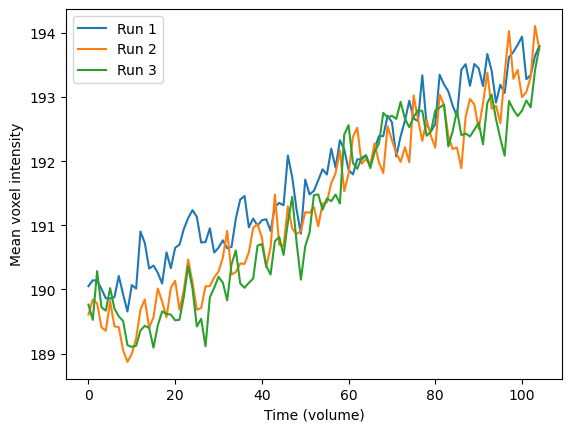

In [30]:
import matplotlib.pyplot as plt
import nibabel as nib
for run in range(1, 4):
    bold_path = op.join(bids_root, 'sub-control01', 'func', 'sub-control01_task-music_run-{}_bold.nii.gz'.format(run))
    bold_img = nib.load(bold_path)
    bold_data = bold_img.get_fdata()
    mean_data = bold_data.mean(axis=(0, 1, 2))
    plt.plot(mean_data, label='Run {}'.format(run))
plt.legend()
plt.xlabel('Time (volume)')
plt.ylabel('Mean voxel intensity')

In [17]:
import matplotlib.pyplot as plt
import nibabel as nib
processed_functional_path = op.join(preproc_root, 'sub-control01', 'func')
functional_path = op.join(bids_root, 'sub-control01', 'func')

In [17]:
def normalize_fMRI(source, output, threshold):
    img = nib.load(source)
    data = img.get_fdata()
    mask = data>=threshold
    masked_data = data[mask]
    mean = masked_data.mean()
    std = masked_data.std()
    normalized = (data - mean)/std
    img_out = nib.Nifti1Image(normalized,img.affine, img.header)
    nib.save(img_out, output)

<h3>Correction of slice 17 in second run</h3>

In [18]:
path_normalized_output_1 = op.join(processed_functional_path, 'sub-control01_task-music_run-1_bold_norm.nii.gz')
path_normalized_output_2 = op.join(processed_functional_path, 'sub-control01_task-music_run-2_bold_norm_.nii.gz')
path_normalized_output_3 = op.join(processed_functional_path, 'sub-control01_task-music_run-3_bold_norm_.nii.gz')
functional_1_path = op.join(functional_path, 'sub-control01_task-music_run-1_bold.nii.gz')
functional_2_path = op.join(functional_path, 'sub-control01_task-music_run-2_bold.nii.gz')
functional_3_path = op.join(functional_path, 'sub-control01_task-music_run-3_bold.nii.gz')

In [28]:
img = nib.load(functional_2_path)
data = img.get_fdata()
data[:, :, 47, 17] = np.mean(data[:, :, 46, 17])
data = data[:, :, :, 1:]
img_out = nib.Nifti1Image(data,img.affine, img.header)
nib.save(img_out, op.join(functional_path, 'sub-control01_task-music_run-2_bold.nii.gz'))

In [ ]:
import matplotlib.pyplot as plt
import nibabel as nib
for run in range(1, 4):
    bold_path = op.join(bids_root, 'sub-control01', 'func', 'sub-control01_task-music_run-{}_bold.nii.gz'.format(run))
    bold_img = nib.load(bold_path)
    bold_data = bold_img.get_fdata()
    mean_data = bold_data.mean(axis=(0, 1, 2))
    plt.plot(mean_data, label='Run {}'.format(run))
plt.legend()
plt.xlabel('Time (volume)')
plt.ylabel('Mean voxel intensity')

In [31]:
normalize_fMRI(functional_1_path, path_normalized_output_1, 200)
normalize_fMRI(functional_2_path, path_normalized_output_2, 200)
normalize_fMRI(functional_3_path, path_normalized_output_3, 200)

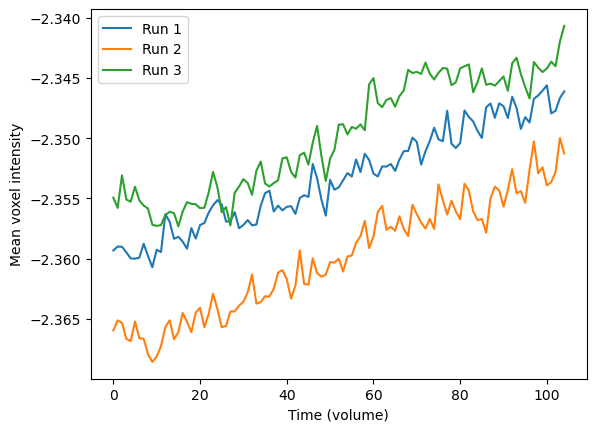

In [32]:
plt.plot(nib.load(path_normalized_output_1).get_fdata().mean(axis=(0,1,2)), label='Run 1')
plt.plot(nib.load(path_normalized_output_2).get_fdata().mean(axis=(0,1,2)), label='Run 2')
plt.plot(nib.load(path_normalized_output_3).get_fdata().mean(axis=(0,1,2)), label='Run 3')
plt.xlabel('Time (volume)')
plt.ylabel('Mean voxel intensity')
plt.legend()
plt.show()

In [34]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(functional_2_path)
fsleyesDisplay.load(path_normalized_output_2)


(ipykernel_launcher.py:161839): Gtk-CRITICAL **: 23:20:53.558: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed

(ipykernel_launcher.py:161839): Gtk-CRITICAL **: 23:20:53.582: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed



(ipykernel_launcher.py:161839): Gtk-CRITICAL **: 23:20:57.124: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed

(ipykernel_launcher.py:161839): Gtk-CRITICAL **: 23:20:57.148: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed

(ipykernel_launcher.py:161839): Gtk-CRITICAL **: 23:20:59.104: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed

(ipykernel_launcher.py:161839): Gtk-CRITICAL **: 23:20:59.126: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed

(ipykernel_launcher.py:161839): Gtk-CRITICAL **: 23:21:02.035: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed

(ipykernel_launcher.py:161839): Gtk-CRITICAL **: 23:21:02.058: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed


<h2>Concatenation of data</h2>

In [19]:
img_1 = nib.load(path_normalized_output_1)
data_1 = img_1.get_fdata()
img_2 = nib.load(path_normalized_output_2)
data_2 = img_2.get_fdata()
img_3 = nib.load(path_normalized_output_3)
data_3 = img_3.get_fdata()

In [20]:
img_1.shape, img_2.shape, img_3.shape

((80, 80, 50, 105), (80, 80, 50, 105), (80, 80, 50, 105))

In [37]:
data = np.concatenate((data_1, data_2, data_3), axis = 3)

In [38]:
functional_concatenated= op.join(functional_path, 'sub-control01_task-music_concat_bold.nii.gz')

In [39]:
img_out = nib.Nifti1Image(data,img_1.affine, img_1.header)
nib.save(img_out, functional_concatenated)

In [40]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(functional_concatenated)


(ipykernel_launcher.py:161839): Gtk-CRITICAL **: 23:22:13.419: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed

(ipykernel_launcher.py:161839): Gtk-CRITICAL **: 23:22:13.443: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed

(ipykernel_launcher.py:161839): Gtk-CRITICAL **: 23:22:13.513: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed

(ipykernel_launcher.py:161839): Gtk-CRITICAL **: 23:22:13.536: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed

(ipykernel_launcher.py:161839): Gtk-CRITICAL **: 23:22:18.889: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed

(ipykernel_launcher.py:161839): Gtk-CRITICAL **: 23:22:18.910: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed



(ipykernel_launcher.py:161839): Gtk-WARNING **: 23:22:18.966: Negative content width -1 (allocation 1, extents 1x1) while allocating gadget (node spinbutton, owner GtkSpinButton)

(ipykernel_launcher.py:161839): Gtk-WARNING **: 23:22:18.966: for_size smaller than min-size (1 < 32) while measuring gadget (node entry, owner GtkSpinButton)

(ipykernel_launcher.py:161839): Gtk-WARNING **: 23:22:18.966: for_size smaller than min-size (1 < 16) while measuring gadget (node button, owner GtkSpinButton)

(ipykernel_launcher.py:161839): Gtk-WARNING **: 23:22:18.966: for_size smaller than min-size (1 < 16) while measuring gadget (node button, owner GtkSpinButton)


## Motion correction

In FSL, we use <a href="https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/MCFLIRT">MCFLIRT</a> to perform this correction.

By default, MCFLIRT selects the middle volume of the EPI serie as reference to which other volumes are realigned.</p>


In [41]:
# path_original_data = os.path.join(bids_root, 'sub-control01', 'func', 'sub-control01_task-music_run-1_bold')
# path_moco_data = os.path.join(preproc_root, 'sub-control01', 'func', 'sub-control01_task-music_run-1_bold_moco')
path_moco_data = op.join(preproc_root, 'sub-control01', 'func', 'sub-control01_task-music_concat_bold.nii.gz')
mcflirt(
    infile=functional_concatenated,  # The input file (original BOLD data)
    o=path_moco_data,           # The output file (motion-corrected data)
    plots=True,                 # Generate plots for visualizing motion correction.
    report=True,                # Generate a report on the motion correction process.
    dof=6,                      # Set degrees of freedom to 6 for rigid-body transformation.
    mats=True                   # Save the transformation matrices.
)

Processed data will be saved as ./data/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_concat_bold.nii.gz

McFLIRT v 2.0 - FMRI motion correction

Reading time series... 
first iteration - 8mm scaling, set tolerance
Rescaling reference volume [157] to 8 mm pixels
Registering volumes ... [158][159][160][161][162][163][164][165][166][167][168][169][170][171][172][173][174][175][176][177][178][179][180][181][182][183][184][185][186][187][188][189][190][191][192][193][194][195][196][197][198][199][200][201][202][203][204][205][206][207][208][209][210][211][212][213][214][215][216][217][218][219][220][221][222][223][224][225][226][227][228][229][230][231][232][233][234][235][236][237][238][239][240][241][242][243][244][245][246][247][248][249][250][251][252][253][254][255][256][257][258][259][260][261][262][263][264][265][266][267][268][269][270][271][272][273][274][275][276][277][278][279][280][281][282][283][284][285][286][287][288][289][290][291][292][2

refnum = 157
Original_refvol = -1


Registering volumes ... [158][159][160][161][162][163][164][165][166][167][168][169][170][171][172][173][174][175][176][177][178][179][180][181][182][183][184][185][186][187][188][189][190][191][192][193][194][195][196][197][198][199][200][201][202][203][204][205][206][207][208][209][210][211][212][213][214][215][216][217][218][219][220][221][222][223][224][225][226][227][228][229][230][231][232][233][234][235][236][237][238][239][240][241][242][243][244][245][246][247][248][249][250][251][252][253][254][255][256][257][258][259][260][261][262][263][264][265][266][267][268][269][270][271][272][273][274][275][276][277][278][279][280][281][282][283][284][285][286][287][288][289][290][291][292][293][294][295][296][297][298][299][300][301][302][303][304][305][306][307][308][309][310][311][312][313][314][156][155][154][153][152][151][150][149][148][147][146][145][144][143][142][141][140][139][138][137][136][135][134][133][132][131][130][129][128][127][126][125][124][123][122][121][120][119][

{}

In [53]:
fsleyesDisplay.resetOverlays() # Reset the overlays in FSLeyes
fsleyesDisplay.load(functional_concatenated) # Load the original data in FSLeyes
fsleyesDisplay.load(path_moco_data) # Load the motion corrected data in FSLeyes


(ipykernel_launcher.py:161839): Gtk-CRITICAL **: 23:36:02.985: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed

(ipykernel_launcher.py:161839): Gtk-CRITICAL **: 23:36:03.007: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed

(ipykernel_launcher.py:161839): Gtk-CRITICAL **: 23:36:03.069: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed

(ipykernel_launcher.py:161839): Gtk-CRITICAL **: 23:36:03.094: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed

(ipykernel_launcher.py:161839): Gtk-CRITICAL **: 23:36:09.403: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed

(ipykernel_launcher.py:161839): Gtk-CRITICAL **: 23:36:09.423: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed

(ipykernel_launcher.py:161839): Gtk-CRITICAL **: 23:36:11.808: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)'


(ipykernel_launcher.py:161839): Gtk-WARNING **: 23:36:11.883: Negative content width -1 (allocation 1, extents 1x1) while allocating gadget (node spinbutton, owner GtkSpinButton)

(ipykernel_launcher.py:161839): Gtk-WARNING **: 23:36:11.883: for_size smaller than min-size (1 < 32) while measuring gadget (node entry, owner GtkSpinButton)

(ipykernel_launcher.py:161839): Gtk-WARNING **: 23:36:11.883: for_size smaller than min-size (1 < 16) while measuring gadget (node button, owner GtkSpinButton)

(ipykernel_launcher.py:161839): Gtk-WARNING **: 23:36:11.883: for_size smaller than min-size (1 < 16) while measuring gadget (node button, owner GtkSpinButton)

(ipykernel_launcher.py:161839): Gtk-CRITICAL **: 23:36:14.274: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed

(ipykernel_launcher.py:161839): Gtk-CRITICAL **: 23:36:14.298: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed


The motion parameters are stored in the .par file produced by MCFLIRT. Notice that since each volume moved differently, we have one transformation per volume, thus one set of motion parameters per volume as well. We provide you with a way to load these parameters:

In [43]:
mot_params = load_mot_params_fsl_6_dof(op.join(preproc_root, 'sub-control01', 'func', 'sub-control01_task-music_concat_bold.nii.gz.par')) 
mot_params # It returns a dataframe with the motion parameters 

,Rotation x,Rotation y,Rotation z,Translation x,Translation y,Translation z
0,-0.002818,0.003264,0.000221,-0.053649,-0.513064,-0.467908
1,-0.003541,0.003037,-0.000225,-0.072016,-0.496912,-0.468315
2,-0.003485,0.003264,-0.000187,-0.061120,-0.476346,-0.456379
3,-0.003376,0.003264,-0.000248,-0.065329,-0.477160,-0.464982
4,-0.002496,0.003192,-0.000324,-0.079537,-0.473894,-0.502713
...,...,...,...,...,...,...
310,0.009169,0.000209,-0.001822,-0.085127,0.392705,0.227226
311,0.009169,0.000177,-0.001978,-0.091338,0.375835,0.224750
312,0.009314,-0.000353,-0.002065,-0.106357,0.406376,0.223947
313,0.008867,-0.000445,-0.002248,-0.106405,0.361294,0.210964


Based on **translation on X alone**, can you find perhaps a volume which exceeds with respect to the **preceding volume** a 0.2 mm displacement?

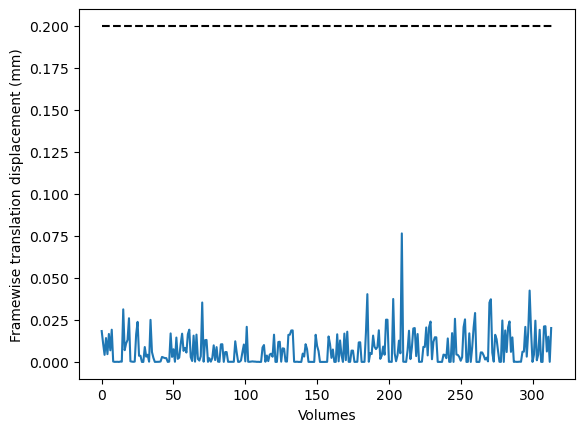

In [44]:
trans_x = mot_params["Translation x"] # Getting the translation on X
# Now, we want a 0.2mm with respect to previous frame:
disp_x = np.diff(trans_x) # Getting the displacement on X. We use np.diff to calculate the difference between consecutive elements in the translation on X.
# Lastly, we can ask for displacements (in absolute value) above 0.2mm and plot it to be clear:
threshold=0.2 
plt.plot(np.abs(disp_x))
plt.hlines(threshold, 0, len(disp_x),colors='black', linestyles='dashed', label='FD threshold')
plt.xlabel("Volumes")
plt.ylabel("Framewise translation displacement (mm)")
plt.show()

Now, we can use the code below to extract an aggregate measure of motion for all volumes. 

In [45]:
fd = compute_FD_power(mot_params).to_numpy()

In [46]:
threshold = np.quantile(fd,0.75) + 1.5*(np.quantile(fd,0.75) - np.quantile(fd,0.25))

In [61]:
import plotly.express as px

fig = px.line(x=list(range(1, fd.size+1)), y=fd, labels={'x': 'Volume', 'y': 'FD displacement (mm)'})
fig.add_hline(y=threshold, line_dash="dash", annotation_text="FD threshold", annotation_position="bottom right")
fig.show()

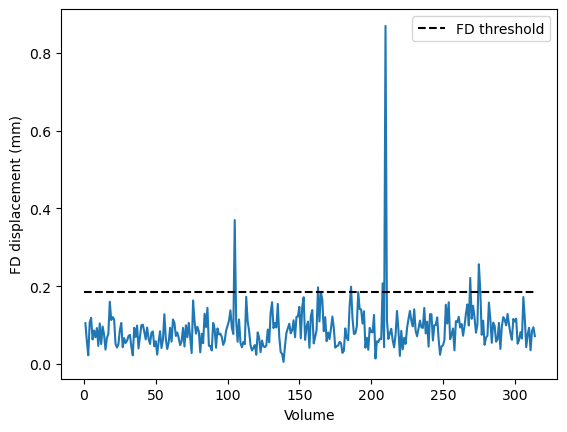

In [47]:
#%matplotlib inline
plt.plot(list(range(1, fd.size+1)), fd)
plt.xlabel('Volume')
plt.ylabel('FD displacement (mm)')
plt.hlines(threshold, 0, len(fd),colors='black', linestyles='dashed', label='FD threshold')
plt.legend()
plt.show()

Okay great, but what if we want to know which volumes are actually above threshold? Simply run the cell below!

In [48]:
np.where(fd > threshold)[0] + 1 

array([105, 163, 186, 208, 210, 269, 275, 276])

In [49]:
#FIXME THERE ARE VOLUMES TO BE REMOVED

## Coregistration of functional to anatomical

You have seen coregistration last week, when you were trying to align the T1 to MNI152, both manually and algorithmically. In the specific case of putting a T1 anatomical in a template space (such as MNI), we call it <b>normalization</b>, because we...Normalize it !

You've also seen above with motion-correction coregistration of EPI volumes (functional data) to each other to correct motion.

But what if you wanted to put the functional data overlayed on the anatomy, to know more precisely which parts of the brain are activated? (**coregistration between functional and anatomical**)

Computing the fMRI space to anatomical transformation is precisely the goal of coregistration.
<br><br>
To do this step, we will use : <a href="https://web.mit.edu/fsl_v5.0.10/fsl/doc/wiki/FLIRT(2f)UserGuide.html#epi_reg">epi_reg</a> ! 

### Using epi_reg to do the EPI registration



<div class="warning" style='background-color:#C1ECFA; color: #112A46; border-left: solid darkblue 4px; border-radius: 4px; padding:0.7em;'>
<span>
<p style='margin-top:1em; text-align:center'><b> 💡 Pay attention ! 💡</b></p>
<p style='text-indent: 10px;'>
    Make sure that the whole head T1 and the skull-stripped T1 have the same orientation.
For example, if you ran fsl_anat to extract the brain (which is fine), FSL will change in the headers the orientation of the T1 before skull-stripping. As a consequence, the brain-extracted T1 no longer has the same orientation as the original T1. If you display them on top of each other, they are perfectly matched, but not from the perspective of the <b>headers</b>, which can play nasty tricks on you when performing coregistration.</p>
</span>
</div>

Note that if parallel acceleration is used in the EPI acquisition then the *effective echo spacing* is the actual echo spacing between acquired lines in k-space divided by the acceleration factor.

epi_reg has one peculiarity. If you launch it on a 4D volume, it will truncate your result to the first volume, because it expects a *single* EPI volume. We should thus first extract a single volume from our EPI, and then call epi_reg on it. We do that for you below.

If you want to run with 4D volume to see the result and the warning, set use_single_vol to False

In [6]:
from fsl.wrappers import epi_reg

#################
# Solution
# We use the motion-corrected EPI
##################

# Define the path to the motion-corrected EPI (functional) image.
epi_target = op.join(preproc_root, 'sub-control01', 'func', 'sub-control01_task-music_concat_bold.nii.gz')

# Define the path to the whole (unprocessed) T1-weighted anatomical image.
whole_t1 = op.join(bids_root, 'sub-control01', 'anat', 'sub-control01_T1w')

# Define the path to the skull-stripped T1-weighted anatomical image.
skull_stripped_t1 = op.join(preproc_root, 'sub-control01', 'anat', 'sub-control01_T1w') # ...

# Define the path where the output of the epi_reg process will be saved.
output_path = op.join(preproc_root, 'sub-control01', 'func', 'sub-control01_task-music_concat_bold_bbr') # ....

# Define the path for the middle volume of the motion-corrected EPI file, which will be extracted as a reference.
ref_vol_name = op.join(preproc_root, 'sub-control01', 'func', 'sub-control01_task-music_concat_bold_moco_vol_middle') 



(ipykernel_launcher.py:67123): Gtk-WARNING **: 15:32:35.772: Negative content width -1 (allocation 1, extents 1x1) while allocating gadget (node spinbutton, owner GtkSpinButton)

(ipykernel_launcher.py:67123): Gtk-WARNING **: 15:32:35.772: for_size smaller than min-size (1 < 32) while measuring gadget (node entry, owner GtkSpinButton)

(ipykernel_launcher.py:67123): Gtk-WARNING **: 15:32:35.772: for_size smaller than min-size (1 < 16) while measuring gadget (node button, owner GtkSpinButton)

(ipykernel_launcher.py:67123): Gtk-WARNING **: 15:32:35.772: for_size smaller than min-size (1 < 16) while measuring gadget (node button, owner GtkSpinButton)


In [7]:

# Set whether to use a single volume as a reference. This can be useful for registration purposes.
use_single_vol = True

if use_single_vol:
    # Extract the middle volume of the EPI image using fslroi. This extracts a single volume from the time series.
    # '182' is the index of the middle volume (assuming the total number of volumes is known). # To change 
    # '1' indicates that only one volume will be extracted.
    fslroi(epi_target, ref_vol_name, str(150), str(1))
    
    # Run epi_reg to register the extracted middle EPI volume to the T1-weighted anatomical image.
    subprocess.run([
        'epi_reg',
        '--epi={}'.format(ref_vol_name),  # The EPI image (middle volume) to be registered.
        '--t1={}'.format(whole_t1),       # The whole, non-skull-stripped T1-weighted image.
        '--t1brain={}'.format(skull_stripped_t1),  # The skull-stripped T1-weighted image.
        '--out={}'.format(output_path)    # The output path where the registered image will be saved.
    ])
else:
    # If not using a single volume, register the entire motion-corrected EPI series to the T1-weighted anatomical image.
    subprocess.run([
        'epi_reg',
        '--epi={}'.format(epi_target),    # The full motion-corrected EPI image (all volumes).
        '--t1={}'.format(whole_t1),       # The whole, non-skull-stripped T1-weighted image.
        '--t1brain={}'.format(skull_stripped_t1),  # The skull-stripped T1-weighted image.
        '--out={}'.format(output_path)    # The output path where the registered image will be saved.
    ])


Running FAST segmentation
FLIRT pre-alignment
Running BBR
0.259556 0.999249 -0.038650 0.002612 0.000000 0.038627 0.999220 0.008267 0.000000 -0.002930 -0.008160 0.999962 0.000000 -4.812857 9.250519 -1.929274 1.000000 



(ipykernel_launcher.py:67123): Gtk-WARNING **: 15:36:20.802: Negative content width -1 (allocation 1, extents 1x1) while allocating gadget (node spinbutton, owner GtkSpinButton)

(ipykernel_launcher.py:67123): Gtk-WARNING **: 15:36:20.802: for_size smaller than min-size (1 < 32) while measuring gadget (node entry, owner GtkSpinButton)

(ipykernel_launcher.py:67123): Gtk-WARNING **: 15:36:20.802: for_size smaller than min-size (1 < 16) while measuring gadget (node button, owner GtkSpinButton)

(ipykernel_launcher.py:67123): Gtk-WARNING **: 15:36:20.802: for_size smaller than min-size (1 < 16) while measuring gadget (node button, owner GtkSpinButton)


In [8]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(skull_stripped_t1)
fsleyesDisplay.load(output_path)


(ipykernel_launcher.py:36937): Gtk-CRITICAL **: 15:08:50.016: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed

(ipykernel_launcher.py:36937): Gtk-CRITICAL **: 15:08:50.042: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed

(ipykernel_launcher.py:36937): Gtk-CRITICAL **: 15:08:50.476: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed

(ipykernel_launcher.py:36937): Gtk-CRITICAL **: 15:08:50.496: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed



(ipykernel_launcher.py:36937): Gtk-WARNING **: 15:08:50.550: Negative content width -1 (allocation 1, extents 1x1) while allocating gadget (node spinbutton, owner GtkSpinButton)

(ipykernel_launcher.py:36937): Gtk-WARNING **: 15:08:50.550: for_size smaller than min-size (1 < 32) while measuring gadget (node entry, owner GtkSpinButton)

(ipykernel_launcher.py:36937): Gtk-WARNING **: 15:08:50.550: for_size smaller than min-size (1 < 16) while measuring gadget (node button, owner GtkSpinButton)

(ipykernel_launcher.py:36937): Gtk-WARNING **: 15:08:50.550: for_size smaller than min-size (1 < 16) while measuring gadget (node button, owner GtkSpinButton)

(ipykernel_launcher.py:36937): Gtk-CRITICAL **: 15:08:55.509: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed

(ipykernel_launcher.py:36937): Gtk-CRITICAL **: 15:08:55.528: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed


Let's overlay the two (EPI and anatomical) on top of each other to visualize the quality of the coregistration!

In [ ]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(skull_stripped_t1)
fsleyesDisplay.load(output_path)


- Is the functional in the right orientation?
- Are the ventricles correctly aligned?
- Are the boundaries of the EPI more or less matching the anatomical?

➡️ You can also check how the white matter of the EPI matches your anatomical's white matter provided you have sufficient resolution

#### Some cleanup
If you have a look, you might notice that perhaps your directory got filled with many files. These are temporary files, created but uncorrectly not eliminated by epi_reg. The following should help:


In [ ]:
def cleanup_epi_reg(path_to_clean):
    patterns = ['*_fast_*', '*_fieldmap*']
    for p in patterns:
        files = glob.glob(op.join(path_to_clean, p))
        for f in files:
            os.remove(f)

In [ ]:
cleanup_epi_reg(op.join(preproc_root, 'sub-control01', 'func'))

In [ ]:
print_dir_tree(bids_root, max_depth=5)

#### Smoothing

All these transforms are not exactly perfect. As you've seen in class, a step of smoothing is typically applied, with the size of the smoothing being dependent on your application, starting resolution etc.
The idea of smoothing is really that, as you're averaging, hopefully you increase the signal to noise ratio. <br>
A side-effect is that finest patterns of activation will be lost in the averaging (we can't have everything: there's no free lunch).

With FSL, smoothing is rather easy to do. However, one thing which is important is the size of your filter.
Different softwares might use different conventions. For MRI, it is typical to talk about FWHM (Full-width at half maximum), expressed in mms.

FSL, however, takes as input in sigma instead of FWHM. The conversion is easy fortunately:

$$ \sigma = \frac{FWHM}{2.3548}$$

Here for example would be the smoothing command for 6mm FWHM smoothing:

In [58]:
# Define the path where the output will be saved (same as input).
# output_path = op.join(preproc_root, 'sub-001', 'func', 'sub-001_task-sitrep_run-01_bold_bbr') # ....

cmd = 'fslmaths {} -s {} {}_smoothed-6mm'.format(output_path, 6/2.3548, output_path)
# This line constructs a command string using 'fslmaths' to apply spatial smoothing to the image.
# - 'fslmaths' is the FSL command used for mathematical manipulation of images.
# - '{}': Placeholder for 'output_path', which is the path to the image that needs smoothing.
# - '-s': This option applies a Gaussian kernel smoothing with a given standard deviation (sigma).
# - '6/2.3548': The value (6 mm divided by 2.3548) converts the full width at half maximum (FWHM) to sigma.
# - '{}_smoothed-6mm': This specifies the output file name, indicating that it has been smoothed with a 6 mm FWHM kernel.

subprocess.run(['fslmaths', output_path, '-s', str(6/2.3548), '{}_smoothed-6mm'.format(output_path)])
# This line runs the 'fslmaths' command directly as a subprocess.
# - 'fslmaths': The command to manipulate the image.
# - 'output_path': The input file path of the image to be smoothed.
# - '-s': The option for applying Gaussian smoothing.
# - 'str(6/2.3548)': The sigma value calculated by converting the 6 mm FWHM value to standard deviation.
# - '{}_smoothed-6mm'.format(output_path)': The output path where the smoothed image will be saved, named with a suffix '_smoothed-6mm'.




CompletedProcess(args=['fslmaths', './data/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_concat_bold_bbr', '-s', '2.547987090198743', './data/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_concat_bold_bbr_smoothed-6mm'], returncode=0)

Let's observe what we have now:

In [59]:
fsleyesDisplay.load(output_path + '_smoothed-6mm')


(ipykernel_launcher.py:161839): Gtk-CRITICAL **: 23:47:13.118: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed

(ipykernel_launcher.py:161839): Gtk-CRITICAL **: 23:47:13.140: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed



(ipykernel_launcher.py:161839): Gtk-CRITICAL **: 23:47:17.026: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed

(ipykernel_launcher.py:161839): Gtk-CRITICAL **: 23:47:17.049: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed

(ipykernel_launcher.py:161839): Gtk-CRITICAL **: 23:50:24.869: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed

(ipykernel_launcher.py:161839): Gtk-CRITICAL **: 23:50:24.891: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed

(ipykernel_launcher.py:161839): Gtk-CRITICAL **: 23:51:21.370: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed

(ipykernel_launcher.py:161839): Gtk-CRITICAL **: 23:51:21.395: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)' failed

(ipykernel_launcher.py:161839): Gtk-CRITICAL **: 00:02:37.046: gtk_combo_box_text_insert: assertion 'GTK_IS_COMBO_BOX_TEXT (combo_box)'

Why does it matter? Well, just applying a back-of the envelope calculation, the first method takes 122s per volume, while the second method takes 87 seconds to combine **once** the transforms excluding motion correction, and 4 seconds per volume to apply the transforms including motion correction. If we plot the two with an increasing number of volumes, we can see why this quickly becomes relevant:

## Slice correction 

#### Application to real data

We have shown you the basic principle, but the application to real data requires some specific informations.
You need the following ingredients:
- When was each slice acquired in the sequence: **(Slice timing)**
- Along which axis were the slices acquired: **Phase direction**
- How much time we take to acquire all slices: **TR**


In [ ]:
data = get_json_from_file(op.join(bids_root, 'sub-001', 'func', 'sub-001_task-sitrep_run-01_bold.json'))
data

This data is actually a dictionary. We can thus extract the slice timing as an array directly from it. For example, to extract TaskName, we would use:
```python
data['TaskName']
```



In [ ]:
slice_timing = data['SliceTiming'] # Replace with the appropriate key (have a look above!)

Now, we might want to know where our slices are, ie along which axis, right? Typically it is along the z-direction, but we're better off if we check! Using FSLeyes, determine how many slices each axis has **for the functional data of interest**. You should thus open the relevant functional file in FSLeyes to answer this question.


<div class="warning" style='background-color:#90EE90; color: #112A46; border-left: solid #805AD5 4px; border-radius: 4px; padding:0.7em;'>
<span>
<p style='margin-top:1em; text-align:center'><b>Using FSL command line</b></p>
<p style='text-indent: 10px;'>To figure out the dimensions of an MRI image, a faster option - if you have FSL installed directly - is to run the command line command:
    <blockquote>fslhd [your_volume]</blockquote>
This will give you all informations contained within the header of the NIfti file. For example, running the command for our volume will easily allow us to access the slice informations:
    <img src="imgs/fslhd_capture.png"></p>
</span>
</div>
Let's compare now with the amount of slices we have in our acquisition. We can consider simply the number of timings for this

In [ ]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(op.join(bids_root, 'sub-001', 'func', 'sub-001_task-sitrep_run-01_bold.nii.gz'))

In [ ]:
len(slice_timing)

Great, so we know which axis we want, we know the slice timings, but we still need to know the TR. This information is also in the JSON sidecar! Extract it now!

In [ ]:
tr = data['RepetitionTime'] # Extract the TR from the sidecar's appropriate field
tr

To now perform the correction, we need to apply FSL's slicetimer command. For this, we need to save the timings first to their own separate file! Instead of giving the slice timings, we will provide instead the slice **order** (ie which slice was done in which order) and let FSL figure out how to best correct based on this information.

Let's do it.

In [ ]:
slice_order = np.argsort(slice_timing) + 1

# Write to a file the corresponding sorted timings :)
timing_path = op.join(preproc_root,  'sub-001', 'func', 'sub-001_task-sitrep_run-01_slice-timings.txt')
file = open(timing_path, mode='w')
for t in slice_order:
    file.write(str(t) + '\n')
file.close()

Finally we can call slicetimer from a terminal!

In [ ]:
file_to_realign = op.join(bids_root, 'sub-001', 'func', 'sub-001_task-sitrep_run-01_bold')
output_target = op.join(preproc_root, 'sub-001', 'func', 'sub-001_task-sitrep_run-01_bold_slice-corr')

subprocess.run(['slicetimer', '-i', file_to_realign, '-o', output_target, '-r', str(tr), '-d', str(3), '--ocustom={}'.format(timing_path)])
#cmd = 'slicetimer -i ' + file_to_realign + ' -o ' + output_target + ' -r ' + str(tr) + ' -d 3 --ocustom=' + timing_path
#os.system(cmd)

In [ ]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(file_to_realign)
fsleyesDisplay.load(output_target)